In [1]:
# Set the path
import sys
sys.path.append("../../")

from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.types import SimulationParameters, ConstantCurrentInjection, RampCurrentInjection
import act.data_processing as dp

import numpy as np
import matplotlib.pyplot as plt

from act.passive import ACTPassiveModule
from act.segregation import ACTSegregator

from sklearn.metrics import mean_absolute_error
from act.metrics import pp_error

In [2]:
# Define the "target" cell
target_cell = ACTCellModel(
    cell_name = "Cell_A",
    path_to_hoc_file = "../../data/LAA/orig/template.hoc",
    path_to_mod_files = "../../data/LAA/orig/modfiles/",
    passive = ["glbar_leak", "el_leak", "ghdbar_hd"],
    active_channels = ["gbar_na3", "gbar_nap", "gkdrbar_kdr", "gsAHPbar_sAHP", "gmbar_im", "gkabar_kap"],
)

In [ ]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "target",
    sim_idx = 0,
    h_celsius = 31,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [RampCurrentInjection(amp_incr = 0.03, num_steps = 5, dur = 300, delay = 100, final_step_add_time = 0)])

simulator.submit_job(target_cell, sim_params)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


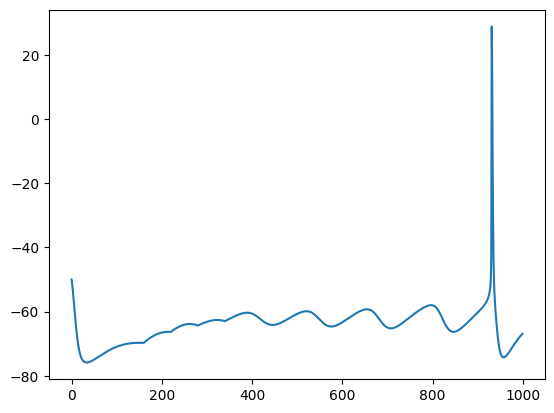

In [4]:
passive_trace = np.load("output/target/out_0.npy")[:, 0]
plt.plot(passive_trace[::10])